In [ ]:
!pip install mysql.connector

     |████████████████████████████████| 11.9MB 319kB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=8b1806ee5eb73a8f0d730a822ca5e252011c47f3c1f3f4ea168058587e1de113
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql.connector


In [ ]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

connection = mysql.connector.connect(host='lambdalabs22sfmta.crqoxlwn3q6h.us-east-2.rds.amazonaws.com',
                                         database='lambdalabs22',
                                         user='admin',
                                         password='13YqLw2Gs3umAVNG9hVe')

# Importing stops data
stops = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/sfmta-data-analysis-ds/master/datasets/route_info.csv')


# Doing this manually, since DB with bus + nearest stop is not fully online.
# For final code, look at 'Exploratory_Clean"
outbound = stops[stops['dir'] == 'Outbound']
inbound = stops[stops['dir'] == 'Inbound']

# Variables that may be user input
rid = '1'
datetime = ''
i_or_o = '%_I_%'

# Filter Stops DF for 1 route
inbound = inbound[inbound['route_id'] == rid]
outbound = outbound[outbound['route_id'] == rid]

## list of route-inbound & route-outbound from stop data -> array of lat/lons
inbound_array = inbound[['lat', 'lon', 'stopId']]
outbound_array = outbound[['lat', 'lon', 'stopId']]

# Stops Array -> Dict
inbound_dict = inbound_array.to_dict()
outbound_dict = outbound_array.to_dict()


# Get dict of 'lat', 'long', 'stopId'
list_dict = []

for key, values in inbound_dict['lon'].items():
  list_dict.append({'stop_lat': inbound_dict['lat'][key], 
                    'stop_lon': values, 
                    'stopId': inbound_dict['stopId'][key]})
  
## database call -> SELECT * FROM historic_location WHERE rid=route & dir CONTAINS __I (inbound) __O (outbound) -> dataframe
cur = connection.cursor()
sql_query = ('''SELECT id, datetime, rid, vid, secs, kph, head, lat, lon, dir
                FROM historic_location
                WHERE rid = %s
                AND
                dir LIKE %s
                LIMIT 1000000;
                ''')

cur.execute(sql_query, (rid, i_or_o))

# Create DF of pertinent columns
# Note: df_inbound = df_key in 'Exploratory_Clean'.
results = cur.fetchall()
df_inbound = pd.DataFrame(results,
                          columns=['id', 'datetime', 'rid', 'vid', 'secs',
                                   'kph', 'head', 'lat', 'lon', 'dir'])

## for loop index, row df.iterrows -> lat = row['lat'] & lon = row['lon]
## -> pass into the function from starter code
from math import cos, asin, sqrt

# Math functions to calculate closest stop
# Could consider importing Haversine. It may work the same or better.
def distance(lat1, lon1, lat2, lon2, stopId):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return [12742 * asin(sqrt(a)), stopId]

def closest(data, v):
    return min(data, key=lambda p: distance(v['lat'],v['lon'],p['stop_lat'],p['stop_lon'], p['stopId']))
    return c_temp[0], c_temp[1]

# Add lat, long from Stops DF and StopId in calculated order to a list
new_values = []
## for loop index, row df.iterrows -> lat = row['lat'] & lon = row['lon]
## -> pass into the function from starter code
for index, row in df_inbound.iterrows():
    lat = row['lat']
    lon = row['lon']
    v = {'lat': float(lat), 'lon': float(lon)}
    new_values.append(closest(list_dict, v))


# Make DF of new_values list
temp_df = pd.DataFrame(new_values)
temp_df.head()

# concatenate queried DF and temp_df list
results = pd.concat([df_inbound, temp_df], axis=1)

# Sort DF by stopId and datetime
results_sorted = results.sort_values(by=['stopId', 'datetime'])

# Stretch: Isolate data for the requested route

# Isolate data for the requested date
cali1_3_29 = results_sorted.loc[(results_sorted['datetime'].dt.month==3) & (results_sorted['datetime'].dt.day==29)]

# Acquire sorted list of bus stops on requested route (from API)
# Possibly must exclude first and last stop (bus stations)
stopIds = [13555, 13548, 13546, 13844, 13842, 13840, 13838, 13836, 13834, 13887,
           1382, 13830, 13827, 13825, 13823, 13846, 13853, 13857, 13876, 13893,
           13848, 13859, 13885, 16489, 16292, 16320, 16292, 16306, 16310, 14905,
           14016, 14031, 14026, 14022, 14019, 14023, 14020, 14030, 14024, 14027,
           14029, 14081, 14021, 14025, 14028, 14017]

# Filter DF for stopIds list
cali1_final =  cali1_3_29[cali1_3_29['stopId'].isin(stopIds)]

# Sort DF by Stops order & datetime
sorterIndex = dict(zip(stopIds,range(len(stopIds))))
cali1_final['stopId_sorted'] = cali1_final['stopId'].map(sorterIndex)

cali1_final.sort_values(['stopId_sorted', 'datetime'],ascending = [True, True], inplace = True)
cali1_final.drop('stopId_sorted', 1, inplace = True)

# Create new column containing time delta between busses
cali1_final['difference'] = cali1_final['datetime'] - cali1_final['datetime'].shift()

# Drop first row of DF due to NaN value (maybe not required)
cali1_final = cali1_final.drop(197990)

# Create a column 'difference' in minutes
cali1_final['difference_min'] = cali1_final['difference'].astype('timedelta64[m]')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [ ]:
# For ease of typing
df = cali1_final

In [ ]:
# Removing negative outliers that don't make sense
# Note: Could be explored to see if they make sense
df = df[(df['difference_min']) >= 0]

In [ ]:
# For ease of typing
x = df['difference_min']

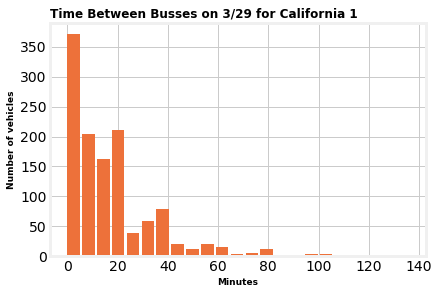

In [ ]:
### Set stylesheet
plt.style.use('fivethirtyeight')

### figure axes syntax
fig, ax = plt.subplots()

### Make the figure background color white
fig.patch.set(facecolor='white')

### put bars on the axes
x.plot.hist(width=5, color='#ED713A', bins=23) ##ED713A #FD5A1E

### Set axes background color
ax.set(facecolor='white')

### Set plot title
ax.set_title("Time Between Busses on 3/29 for California 1", fontsize=12, fontweight='bold', x=.410, y=1.0) 

### Set plot ylabel
ax.set_ylabel('Number of vehicles', fontsize=9, fontweight='bold')

### Set plot xlabel
ax.set_xlabel('Minutes', fontsize=9, fontweight='bold')


fig.show()

In [ ]:
df_inbound.head(2)

,id,datetime,rid,vid,secs,kph,head,lat,lon,dir
0,35,2020-01-20 14:52:28,1,5816,89,34,75,37.786701,-122.450996,1____I_F00
1,89,2020-01-20 14:52:28,1,5796,33,0,79,37.793499,-122.413002,1____I_F00


In [ ]:
stops.head(2)

,route_id,lat,lon,stopId,tag,title,dir
0,E,37.80713,-122.41732,15184,5184,Jones St & Beach St,Outbound
1,E,37.80741,-122.41412,13092,3092,Beach St & Mason St,Outbound


In [ ]:
df.head(2)

,id,datetime,rid,vid,secs,kph,head,lat,lon,dir,stop_lat,stop_lon,stopId,difference,difference_min
198052,11939142,2020-03-29 14:54:38,1,5771,8,35,0,37.781399,-122.492996,1____I_F00,37.78154,-122.49335,13555,00:17:20,17.0
198088,11941397,2020-03-29 15:02:46,1,5842,25,16,345,37.781300,-122.492996,1____I_F00,37.78154,-122.49335,13555,00:08:08,8.0


In [ ]:
# Notes on how to proceed

## Plot B&G
# Add schedule to dataset
# Define B&G for that data
## Note: changes across the day
# Make new column with 0/1/2 for Neutral/B/G??
# Plot the new column
# See: https://muni.opentransit.city/route/1/1/14277/14017 (Service Frequency)